# COMPUTATION OF POWER SPECTRAL DENSITY (PSD) ON EEG DATA AND COMPARISONS OF CONDITIONS WITH T-TEST

## Imports

In [1]:
import mne # Here we import mne, the package that will contain most of the function that we will use
%matplotlib notebook
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Constants

In [2]:
#Declaration of the constants
PARTICIPANTS = ['01', '04', '05', '06', '07', '09', '11', '12', '13', '14']
PARTICIPANTS_DROP_CH = ['09', '11', '12', '13', '14']

event_id_names = [
            'S1_p', 'S1_i',
            'S2_p', 
            'S2_i', 
            'S3_p', 'S3_i',
            'S4_p', 'S4_i',
            'S11_p', 'S11_i',
            'S12_p', 'S12_i', 
            'S13_p', 'S13_i',
            'S14_p', 'S14_i',
            'S21_p', 'S21_i',
            'S22_p', 'S22_i', 
            'S23_p', 'S23_i',
            'S24_p', 'S24_i']
PERCEPT = ['S1_p', 'S2_p', 'S3_p','S4_p', 'S11_p','S12_p', 'S13_p','S14_p','S21_p','S22_p', 'S23_p','S24_p',]
IMAGINED = ['S1_i', 'S2_i', 'S3_i','S4_i', 'S11_i','S12_i', 'S13_i','S14_i','S21_i','S22_i', 'S23_i','S24_i',]

event_id_cond_names = ['Percept', 'Imagine_cued']

FREQ_BANDS = [[1, 3], [4, 7], [8, 12], [13, 29], [30, 45]]
FREQ_NAMES = ['delta', 'theta', 'alpha', 'beta', 'gamma']
EEG = [i for i in range(64)]

## Functions

In [18]:
#This function takes values and sensor positions and output an array of topoplots. 
def array_topoplot(toplot, ch_xy, showtitle=False, titles=None, savefig=True, figpath=r'C:\Users\Dell\Jupyter\BrainHackSchool2019_AB\EEG_music_scripts', vmin=-1, vmax=1, mask = None):
    #create fig
    fig, ax = plt.subplots(1,len(toplot), figsize=(10,5))
    #create a topomap for each data array
    for i, data in enumerate(toplot):
        image,_ = mne.viz.plot_topomap(data=data, pos=ch_xy, cmap='magma', vmin=vmin, vmax=vmax, axes=ax[i], show=False, mask = mask[i, :])
        #option for title
        if showtitle == True:
            ax[i].set_title(titles[i], fontdict={'fontsize': 10, 'fontweight': 'heavy'})
    #add a colorbar at the end of the line (weird trick from https://www.martinos.org/mne/stable/auto_tutorials/stats-sensor-space/plot_stats_spatio_temporal_cluster_sensors.html#sphx-glr-auto-tutorials-stats-sensor-space-plot-stats-spatio-temporal-cluster-sensors-py)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[-1])
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_colorbar.tick_params(labelsize=8)
    #save plot if specified
    if savefig == True:
        plt.savefig(figpath, dpi=300)
    plt.show()
    return fig, ax


In [15]:
#Compute Power Spectral Density (PSD) for each participant/frequency band/electrode, and return a 3D matrix

def compute_psd(data=None, function=psd_welch, condition='Percept'):
    psds_tot = []
    for p in PARTICIPANTS: 
        psds_temp = []
        for min, max in FREQ_BANDS:
            psds, freqs = function(epoched_data[p][condition], fmin=min, fmax=max, n_jobs=1, picks = EEG)
            print(freqs)
            print(psds.shape)
            psds = 10. * np.log10(psds)
            psds_mean = np.average(psds, axis=0)
            psds_mean = np.average(psds_mean, axis=1)
            psds_temp.append(psds_mean)
        psds_tot.append(psds_temp)
    #Matrix for perception conditions (10*5*64)    
    psds_tot = np.array(psds_tot)
    return psds_tot

In [5]:
#Compute T-test (compare percept vs. imagined conditions)
# sub * freq * elec
def compute_t_test(data1, data2):
    results = []
    for freq in range(data1.shape[1]):
        results_temp = []
        for elec in range(data1.shape[2]):
            data1_t_test = data1[:, freq, elec]
            data2_t_test = data2[:,freq, elec]
            results_temp.append(stats.ttest_rel(data1_t_test, data2_t_test))
        results.append(results_temp)
    results = np.array(results)
    t_values = results[:,:,0]
    p_values = results[:,:,1]
    return (results, t_values, p_values)

#Create a mask of p-values for plot topomap
def p_values_boolean(p_values):
    p_values_boolean = p_values.copy()
    for e in range(p_values.shape[1]):
        for c in range(p_values.shape[0]):
            if p_values[c, e] < 0.05:
                p_values_boolean[c, e] = True
            else:
                p_values_boolean[c, e] = False
    p_values_boolean = np.array(p_values_boolean, dtype='bool')                
    return(p_values_boolean)

## Loading EEG data

In [6]:
#Load Epoched data
data_path = r'C:\Users\Dell\Jupyter\MNE_python'
epoched_data = {}
for p in PARTICIPANTS:
    fnames = (data_path + '\\' + 'epoched_data_cond' + p +'.fif.gz') #epoched_data_cond for simple percept/imagine contrast
                                                                     #epoched_data for having song contrast as well
    epoched_data[p] = mne.read_epochs(fnames, preload=True)
    #Baseline correction : Correction is applied by computing mean of the baseline period and subtracting it from the data
    epoched_data[p] = epoched_data[p].apply_baseline((-0.5, -0.1))
#Drop unnecessary channels (EXG5 and EXG6) for participants higher than p09 (non-consistant in data structure)
for p in PARTICIPANTS_DROP_CH:
    epoched_data[p].drop_channels('EXG6')
    epoched_data[p].drop_channels('EXG5')
#epoched_data['04'].info['ch_names']
#Get EEG 64 electrodes layout positions    
layout = mne.channels.find_layout(epoched_data['07'].info, ch_type='eeg')
ch_xy = layout.pos[:,0:2]

Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond01.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond01.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond04.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond04.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond05.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond05.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond06.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond06.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond07.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond07.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond09.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond09.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 66) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond11.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond11.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 66) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond12.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond12.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 66) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond13.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond13.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 66) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond14.fif.gz ...


<ipython-input-6-d1ff3f52dcca>:7: RuntimeWarning: This filename (C:\Users\Dell\Jupyter\MNE_python\epoched_data_cond14.fif.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data[p] = mne.read_epochs(fnames, preload=True)


    Read a total of 1 projection items:
        Average EEG reference (1 x 66) active
    Found the data of interest:
        t =    -500.00 ...    6800.78 ms
        0 CTF compensation matrices available
120 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)


## Compute PSD

In [9]:
#Compute PSD with Welch algorithm
psds_percept_welch = compute_psd(epoched_data, psd_welch, 'Percept')
psds_imagined_welch = compute_psd(epoched_data, psd_welch, 'Imagine_cued')
#Compute PSD with multitaper algorithm
psds_percept_multitaper = compute_psd(epoched_data, psd_multitaper, 'Percept')
psds_imagined_multitaper = compute_psd(epoched_data, psd_multitaper, 'Imagine_cued')

Effective window size : 0.500 (s)
[2.]
(60, 64, 1)
Effective window size : 0.500 (s)
[4. 6.]
(60, 64, 2)
Effective window size : 0.500 (s)
[ 8. 10. 12.]
(60, 64, 3)
Effective window size : 0.500 (s)
[14. 16. 18. 20. 22. 24. 26. 28.]
(60, 64, 8)
Effective window size : 0.500 (s)
[30. 32. 34. 36. 38. 40. 42. 44.]
(60, 64, 8)
Effective window size : 0.500 (s)
[2.]
(60, 64, 1)
Effective window size : 0.500 (s)
[4. 6.]
(60, 64, 2)
Effective window size : 0.500 (s)
[ 8. 10. 12.]
(60, 64, 3)
Effective window size : 0.500 (s)
[14. 16. 18. 20. 22. 24. 26. 28.]
(60, 64, 8)
Effective window size : 0.500 (s)
[30. 32. 34. 36. 38. 40. 42. 44.]
(60, 64, 8)
Effective window size : 0.500 (s)
[2.]
(60, 64, 1)
Effective window size : 0.500 (s)
[4. 6.]
(60, 64, 2)
Effective window size : 0.500 (s)
[ 8. 10. 12.]
(60, 64, 3)
Effective window size : 0.500 (s)
[14. 16. 18. 20. 22. 24. 26. 28.]
(60, 64, 8)
Effective window size : 0.500 (s)
[30. 32. 34. 36. 38. 40. 42. 44.]
(60, 64, 8)
Effective window size : 0

    Using multitaper spectrum estimation with 7 DPSS windows
[30.12570206 30.26263707 30.39957208 30.53650709 30.6734421  30.81037711
 30.94731212 31.08424712 31.22118213 31.35811714 31.49505215 31.63198716
 31.76892217 31.90585718 32.04279219 32.1797272  32.31666221 32.45359722
 32.59053223 32.72746724 32.86440225 33.00133726 33.13827227 33.27520727
 33.41214228 33.54907729 33.6860123  33.82294731 33.95988232 34.09681733
 34.23375234 34.37068735 34.50762236 34.64455737 34.78149238 34.91842739
 35.0553624  35.19229741 35.32923242 35.46616742 35.60310243 35.74003744
 35.87697245 36.01390746 36.15084247 36.28777748 36.42471249 36.5616475
 36.69858251 36.83551752 36.97245253 37.10938754 37.24632255 37.38325756
 37.52019256 37.65712757 37.79406258 37.93099759 38.0679326  38.20486761
 38.34180262 38.47873763 38.61567264 38.75260765 38.88954266 39.02647767
 39.16341268 39.30034769 39.4372827  39.57421771 39.71115271 39.84808772
 39.98502273 40.12195774 40.25889275 40.39582776 40.53276277 40.

    Using multitaper spectrum estimation with 7 DPSS windows
[1.09548007 1.23241508 1.36935009 1.5062851  1.64322011 1.78015512
 1.91709013 2.05402514 2.19096015 2.32789516 2.46483017 2.60176518
 2.73870019 2.8756352 ]
(60, 64, 14)
    Using multitaper spectrum estimation with 7 DPSS windows
[4.10805028 4.24498529 4.3819203  4.51885531 4.65579032 4.79272533
 4.92966034 5.06659535 5.20353036 5.34046537 5.47740037 5.61433538
 5.75127039 5.8882054  6.02514041 6.16207542 6.29901043 6.43594544
 6.57288045 6.70981546 6.84675047 6.98368548]
(60, 64, 22)
    Using multitaper spectrum estimation with 7 DPSS windows
[ 8.07916555  8.21610056  8.35303557  8.48997058  8.62690559  8.7638406
  8.90077561  9.03771062  9.17464563  9.31158064  9.44851565  9.58545066
  9.72238566  9.85932067  9.99625568 10.13319069 10.2701257  10.40706071
 10.54399572 10.68093073 10.81786574 10.95480075 11.09173576 11.22867077
 11.36560578 11.50254079 11.6394758  11.77641081 11.91334581]
(60, 64, 29)
    Using multitaper

    Using multitaper spectrum estimation with 7 DPSS windows
[ 8.07916555  8.21610056  8.35303557  8.48997058  8.62690559  8.7638406
  8.90077561  9.03771062  9.17464563  9.31158064  9.44851565  9.58545066
  9.72238566  9.85932067  9.99625568 10.13319069 10.2701257  10.40706071
 10.54399572 10.68093073 10.81786574 10.95480075 11.09173576 11.22867077
 11.36560578 11.50254079 11.6394758  11.77641081 11.91334581]
(60, 64, 29)
    Using multitaper spectrum estimation with 7 DPSS windows
[13.00882589 13.1457609  13.28269591 13.41963092 13.55656593 13.69350094
 13.83043595 13.96737095 14.10430596 14.24124097 14.37817598 14.51511099
 14.652046   14.78898101 14.92591602 15.06285103 15.19978604 15.33672105
 15.47365606 15.61059107 15.74752608 15.88446109 16.0213961  16.1583311
 16.29526611 16.43220112 16.56913613 16.70607114 16.84300615 16.97994116
 17.11687617 17.25381118 17.39074619 17.5276812  17.66461621 17.80155122
 17.93848623 18.07542124 18.21235624 18.34929125 18.48622626 18.62316127
 1

[13.00882589 13.1457609  13.28269591 13.41963092 13.55656593 13.69350094
 13.83043595 13.96737095 14.10430596 14.24124097 14.37817598 14.51511099
 14.652046   14.78898101 14.92591602 15.06285103 15.19978604 15.33672105
 15.47365606 15.61059107 15.74752608 15.88446109 16.0213961  16.1583311
 16.29526611 16.43220112 16.56913613 16.70607114 16.84300615 16.97994116
 17.11687617 17.25381118 17.39074619 17.5276812  17.66461621 17.80155122
 17.93848623 18.07542124 18.21235624 18.34929125 18.48622626 18.62316127
 18.76009628 18.89703129 19.0339663  19.17090131 19.30783632 19.44477133
 19.58170634 19.71864135 19.85557636 19.99251137 20.12944638 20.26638139
 20.40331639 20.5402514  20.67718641 20.81412142 20.95105643 21.08799144
 21.22492645 21.36186146 21.49879647 21.63573148 21.77266649 21.9096015
 22.04653651 22.18347152 22.32040653 22.45734154 22.59427654 22.73121155
 22.86814656 23.00508157 23.14201658 23.27895159 23.4158866  23.55282161
 23.68975662 23.82669163 23.96362664 24.10056165 24.2

    Using multitaper spectrum estimation with 7 DPSS windows
[30.12570206 30.26263707 30.39957208 30.53650709 30.6734421  30.81037711
 30.94731212 31.08424712 31.22118213 31.35811714 31.49505215 31.63198716
 31.76892217 31.90585718 32.04279219 32.1797272  32.31666221 32.45359722
 32.59053223 32.72746724 32.86440225 33.00133726 33.13827227 33.27520727
 33.41214228 33.54907729 33.6860123  33.82294731 33.95988232 34.09681733
 34.23375234 34.37068735 34.50762236 34.64455737 34.78149238 34.91842739
 35.0553624  35.19229741 35.32923242 35.46616742 35.60310243 35.74003744
 35.87697245 36.01390746 36.15084247 36.28777748 36.42471249 36.5616475
 36.69858251 36.83551752 36.97245253 37.10938754 37.24632255 37.38325756
 37.52019256 37.65712757 37.79406258 37.93099759 38.0679326  38.20486761
 38.34180262 38.47873763 38.61567264 38.75260765 38.88954266 39.02647767
 39.16341268 39.30034769 39.4372827  39.57421771 39.71115271 39.84808772
 39.98502273 40.12195774 40.25889275 40.39582776 40.53276277 40.

    Using multitaper spectrum estimation with 7 DPSS windows
[1.09548007 1.23241508 1.36935009 1.5062851  1.64322011 1.78015512
 1.91709013 2.05402514 2.19096015 2.32789516 2.46483017 2.60176518
 2.73870019 2.8756352 ]
(60, 64, 14)
    Using multitaper spectrum estimation with 7 DPSS windows
[4.10805028 4.24498529 4.3819203  4.51885531 4.65579032 4.79272533
 4.92966034 5.06659535 5.20353036 5.34046537 5.47740037 5.61433538
 5.75127039 5.8882054  6.02514041 6.16207542 6.29901043 6.43594544
 6.57288045 6.70981546 6.84675047 6.98368548]
(60, 64, 22)
    Using multitaper spectrum estimation with 7 DPSS windows
[ 8.07916555  8.21610056  8.35303557  8.48997058  8.62690559  8.7638406
  8.90077561  9.03771062  9.17464563  9.31158064  9.44851565  9.58545066
  9.72238566  9.85932067  9.99625568 10.13319069 10.2701257  10.40706071
 10.54399572 10.68093073 10.81786574 10.95480075 11.09173576 11.22867077
 11.36560578 11.50254079 11.6394758  11.77641081 11.91334581]
(60, 64, 29)
    Using multitaper

    Using multitaper spectrum estimation with 7 DPSS windows
[ 8.07916555  8.21610056  8.35303557  8.48997058  8.62690559  8.7638406
  8.90077561  9.03771062  9.17464563  9.31158064  9.44851565  9.58545066
  9.72238566  9.85932067  9.99625568 10.13319069 10.2701257  10.40706071
 10.54399572 10.68093073 10.81786574 10.95480075 11.09173576 11.22867077
 11.36560578 11.50254079 11.6394758  11.77641081 11.91334581]
(60, 64, 29)
    Using multitaper spectrum estimation with 7 DPSS windows
[13.00882589 13.1457609  13.28269591 13.41963092 13.55656593 13.69350094
 13.83043595 13.96737095 14.10430596 14.24124097 14.37817598 14.51511099
 14.652046   14.78898101 14.92591602 15.06285103 15.19978604 15.33672105
 15.47365606 15.61059107 15.74752608 15.88446109 16.0213961  16.1583311
 16.29526611 16.43220112 16.56913613 16.70607114 16.84300615 16.97994116
 17.11687617 17.25381118 17.39074619 17.5276812  17.66461621 17.80155122
 17.93848623 18.07542124 18.21235624 18.34929125 18.48622626 18.62316127
 1

[13.00882589 13.1457609  13.28269591 13.41963092 13.55656593 13.69350094
 13.83043595 13.96737095 14.10430596 14.24124097 14.37817598 14.51511099
 14.652046   14.78898101 14.92591602 15.06285103 15.19978604 15.33672105
 15.47365606 15.61059107 15.74752608 15.88446109 16.0213961  16.1583311
 16.29526611 16.43220112 16.56913613 16.70607114 16.84300615 16.97994116
 17.11687617 17.25381118 17.39074619 17.5276812  17.66461621 17.80155122
 17.93848623 18.07542124 18.21235624 18.34929125 18.48622626 18.62316127
 18.76009628 18.89703129 19.0339663  19.17090131 19.30783632 19.44477133
 19.58170634 19.71864135 19.85557636 19.99251137 20.12944638 20.26638139
 20.40331639 20.5402514  20.67718641 20.81412142 20.95105643 21.08799144
 21.22492645 21.36186146 21.49879647 21.63573148 21.77266649 21.9096015
 22.04653651 22.18347152 22.32040653 22.45734154 22.59427654 22.73121155
 22.86814656 23.00508157 23.14201658 23.27895159 23.4158866  23.55282161
 23.68975662 23.82669163 23.96362664 24.10056165 24.2

    Using multitaper spectrum estimation with 7 DPSS windows
[30.12570206 30.26263707 30.39957208 30.53650709 30.6734421  30.81037711
 30.94731212 31.08424712 31.22118213 31.35811714 31.49505215 31.63198716
 31.76892217 31.90585718 32.04279219 32.1797272  32.31666221 32.45359722
 32.59053223 32.72746724 32.86440225 33.00133726 33.13827227 33.27520727
 33.41214228 33.54907729 33.6860123  33.82294731 33.95988232 34.09681733
 34.23375234 34.37068735 34.50762236 34.64455737 34.78149238 34.91842739
 35.0553624  35.19229741 35.32923242 35.46616742 35.60310243 35.74003744
 35.87697245 36.01390746 36.15084247 36.28777748 36.42471249 36.5616475
 36.69858251 36.83551752 36.97245253 37.10938754 37.24632255 37.38325756
 37.52019256 37.65712757 37.79406258 37.93099759 38.0679326  38.20486761
 38.34180262 38.47873763 38.61567264 38.75260765 38.88954266 39.02647767
 39.16341268 39.30034769 39.4372827  39.57421771 39.71115271 39.84808772
 39.98502273 40.12195774 40.25889275 40.39582776 40.53276277 40.

## Compute T-test to compare perception and imagination on each electrode

In [11]:
results_welch, t_welch, p_welch = compute_t_test(psds_percept_welch, psds_imagined_welch)
p_welch_boolean = p_values_boolean(p_welch)
results_multitaper, t_multitaper, p_multitaper = compute_t_test(psds_percept_multitaper, psds_imagined_multitaper)
p_welch_multitaper = p_values_boolean(p_multitaper)

## Plot topomaps

<IPython.core.display.Javascript object>


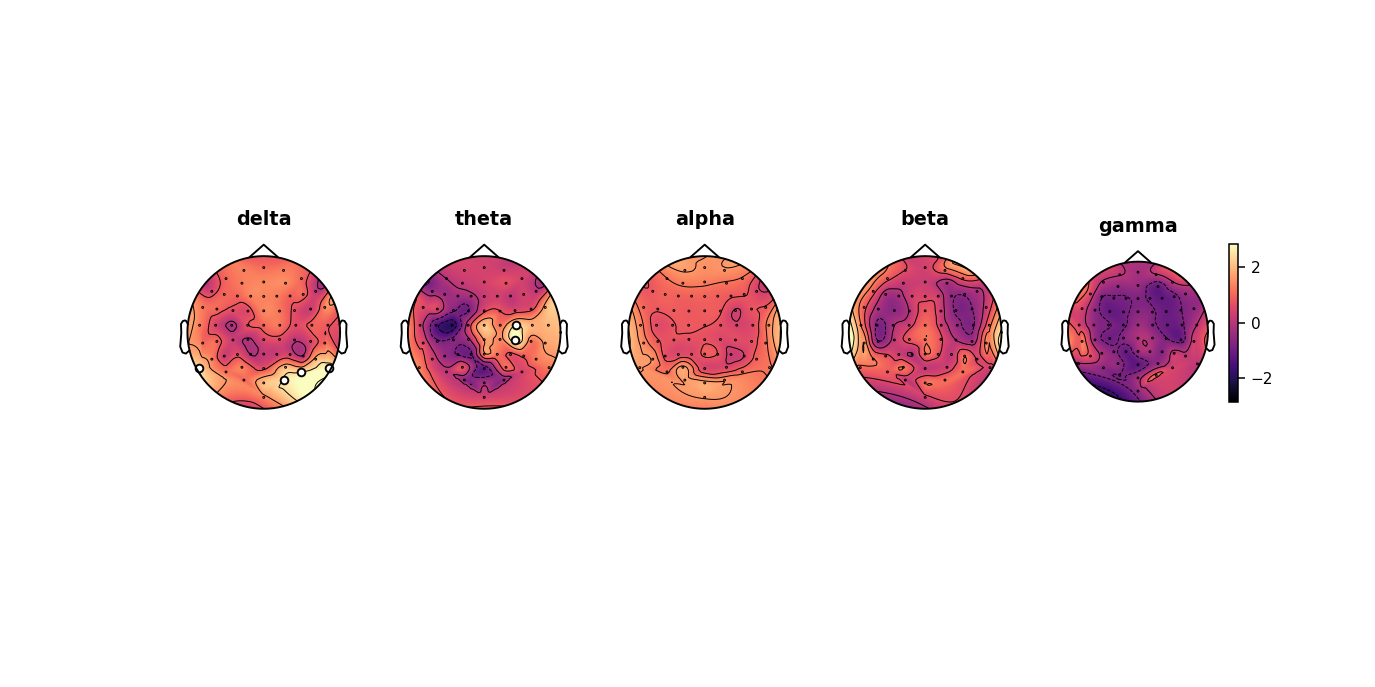

In [19]:
value_to_plot = t_welch
extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot))))))
vmax = extreme
vmin = -extreme
#value_to_plot2 = psds_percept_avg
array_topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True, titles=FREQ_NAMES, mask = p_welch_boolean);
#array_topoplot(value_to_plot2, ch_xy, vmin=np.min(np.min(np.array(value_to_plot2))), vmax=np.max(np.max(np.array(value_to_plot2))), showtitle=True, titles=FREQ_NAMES);

In [ ]:
#Subtract one condition to another
# sub * freq * elec
psds_sub = ((np.average(psds_imagined_tot, axis=0))-(np.average(psds_percept_tot, axis=0)))/(np.average(psds_percept_tot, axis=0))

#Average PSDs across participants
percept_avg = np.average(psds_percept_tot, axis=0)
imagined_avg = np.average(psds_imagined_tot, axis=0)
#for idx in range(imagined_avg.shape[0]):
#    psds_imagined_avg.append(imagined_avg[idx,:])  
#psds_imagined_avg = np.array(psds_imagined_avg)
    


# Plot PSDs in low-frequency range to find peaks related to beat perception

In [ ]:
#epoched_data['01'][['S1_p', 'S2_p', 'S3_p']].plot_psd(fmin=0, fmax=3, tmin=0.5);
#epoched_data['01'].plot_psd(fmin=0, fmax=3, tmin=0.5, bandwidth=4);
epoched_data['01'].plot_raw_psd(fmin=0, fmax=3, tmin=0.5, bandwidth=4);
#epoched_data['01'].plot_image();

In [ ]:
psds_percept_welch = compute_psd(epoched_data, psd_welch, 'Percept')

In [ ]:
def compute_psd_lowfreq(data=epoched_data, function=psd_welch, condition='Percept'):
    psds_low = []
    psds_mean = []
    for p in PARTICIPANTS: 
        psds, freqs = function(epoched_data[p][condition], fmin=min, fmax=max, n_jobs=1, picks = EEG, n_fft=1024)
        psds = 10. * np.log10(psds)
        psds_mean = np.average(psds, axis=0)
        psds_mean = np.average(psds_mean, axis=1)
        psds_low.append(psds_mean)
        
    #Matrix for perception conditions (10*5*64)    
    #psds_low = np.array(psds)
    return psds_low

In [ ]:
#psd_low = compute_psd_lowfreq(epoched_data, psd_welch, 'Percept')
#psd_low = np.array(psd_low)


In [ ]:
epoched_data['07']["Percept"].average().plot_joint(times='peaks', ts_args=dict(gfp=True));

In [ ]:
epoched_data['13']['Percept'].plot_psd_topomap();
#epoched_data['13']['Imagine_cued'].plot_psd_topomap();